In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "HSF"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn029931,MYIYDGTQFPIKHEEYLKLDHDEREEVIEAWYMDDSHEDQRLPHHR...,518,1
1,Achn057551,MNKSHKAVPAPFLTKTYQLVDDPSSDHIVSWGEDDTTFVVWRPQEF...,310,1
2,Achn081581,MEGLLKRIMRFMNHIELTIEHQGETRINDDGSLSPARGRFEDSTVD...,343,1
3,Achn086291,MSPDDKPPFSHSKSPSYSSCLPGSEPESSIIPPASSSSAQFKSGFS...,512,1
4,Achn091321,MGQRSVPAPFLMKTYKLVDDQSTDEVIGWNEGGTTFVVWKTDNFSK...,481,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
768,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.029851,0.007463,...,0.00000,0.0000,0.007463,0.0,0.00000,0.0,0.007463,0.0,0.0,0.00000
884,0.000000,0.0,0.000000,0.006849,0.006849,0.000000,0.000000,0.00000,0.006849,0.000000,...,0.00000,0.0000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.00000
431,0.010941,0.0,0.017505,0.004376,0.002188,0.000000,0.002188,0.00000,0.002188,0.000000,...,0.00000,0.0000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.00000
2725,0.033223,0.0,0.003322,0.003322,0.003322,0.003322,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.0000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.00000
7947,0.005900,0.0,0.000000,0.008850,0.000000,0.000000,0.005900,0.00295,0.000000,0.014749,...,0.00295,0.0059,0.000000,0.0,0.00295,0.0,0.002950,0.0,0.0,0.00295


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7295, 441)
X_test: (1824, 441)
y_train: (7295,)
y_test: (1824,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 57s 635ms/step - accuracy: 0.4219 - loss: 0.6931

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5576 - loss: 0.6884   

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6594 - loss: 0.6607

77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7238 - loss: 0.5967

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7502 - loss: 0.5589 - val_accuracy: 0.9815 - val_loss: 0.0520


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0355

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0464 

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9887 - loss: 0.0431

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0430

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0429 - val_accuracy: 0.9849 - val_loss: 0.0446


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0130

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0313 

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0278

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0286

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9919 - loss: 0.0300 - val_accuracy: 0.9849 - val_loss: 0.0440


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0128

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0135 

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0187

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0217

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9930 - loss: 0.0228 - val_accuracy: 0.9870 - val_loss: 0.0433


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0017

23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0186 

47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0180

70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0177

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0178 - val_accuracy: 0.9856 - val_loss: 0.0559


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0504

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0206 

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0203

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0195

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0187 - val_accuracy: 0.9883 - val_loss: 0.0444


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0017

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0090 

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0114

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0128

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0136 - val_accuracy: 0.9890 - val_loss: 0.0449


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0025

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0031 

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0058

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0076

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0093 - val_accuracy: 0.9842 - val_loss: 0.0641


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0061

26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0040 

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0061

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0086

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0102 - val_accuracy: 0.9877 - val_loss: 0.0459


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0026

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0057 

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0084

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0088

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0093 - val_accuracy: 0.9890 - val_loss: 0.0452


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0116

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0101 

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0083

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0083

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0086 - val_accuracy: 0.9897 - val_loss: 0.0477


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 4.7426e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0044     

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0084

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0096

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0101 - val_accuracy: 0.9657 - val_loss: 0.1380


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0390

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0098 

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0082

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0080

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0079 - val_accuracy: 0.9863 - val_loss: 0.0507


Epoch 14/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0052

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0045 

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0037

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0034

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0041 - val_accuracy: 0.9849 - val_loss: 0.0549


Epoch 15/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0011

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0046 

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0070

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0077

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0081 - val_accuracy: 0.9863 - val_loss: 0.0537


Epoch 16/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 7.9769e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0029     

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0052

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0058

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0061 - val_accuracy: 0.9856 - val_loss: 0.0644


Epoch 17/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 4.7243e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.4452e-04 

47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0016    

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0046

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0061 - val_accuracy: 0.9849 - val_loss: 0.0595


Epoch 18/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0018

23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0047 

46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0049

69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0058

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0064 - val_accuracy: 0.9856 - val_loss: 0.0540


Epoch 19/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0016

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0022 

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0029

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0033

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0043 - val_accuracy: 0.9863 - val_loss: 0.0553


Epoch 20/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 8.1756e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0076     

47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0085

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0078

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0074 - val_accuracy: 0.9877 - val_loss: 0.0575


Epoch 21/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0013

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0084 

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0103

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0104

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0101 - val_accuracy: 0.9856 - val_loss: 0.0558



[Train Accuracy: 99.76% - Test Accuracy: 98.90%]


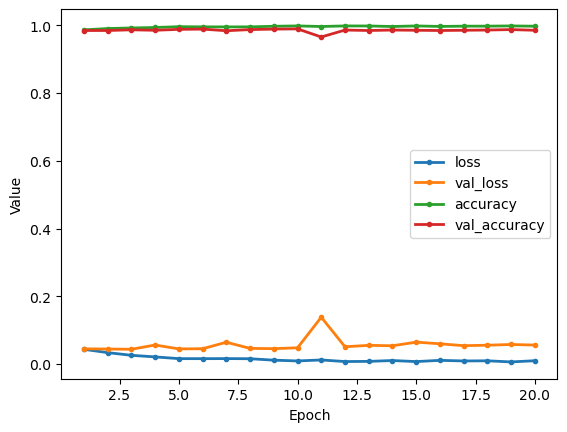

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step


 1/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
768,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
884,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431,0.004386,0.0,0.0,0.002193,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2725,0.016667,0.0,0.0,0.003333,0.0,0.003333,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7947,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.002959,0.0,0.0,0.002959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7295, 8905)
X_test: (1824, 8905)
y_train: (7295,)
y_test: (1824,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,279,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,323,201 (8.86 MB)

 Trainable params: 2,323,201 (8.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 58s 642ms/step - accuracy: 0.5312 - loss: 0.6931

 6/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5246 - loss: 0.6928  

13/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5941 - loss: 0.6917 

20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6530 - loss: 0.6890

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6956 - loss: 0.6841

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7310 - loss: 0.6743

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7577 - loss: 0.6587

51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7788 - loss: 0.6375

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7961 - loss: 0.6133

67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8105 - loss: 0.5885

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8213 - loss: 0.5673

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8307 - loss: 0.5473

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8391 - loss: 0.5284

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8445 - loss: 0.5157 - val_accuracy: 0.9945 - val_loss: 0.0143


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0017

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0052 

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0075

22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9988 - loss: 0.0085

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9986 - loss: 0.0093

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9984 - loss: 0.0098

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0101

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9982 - loss: 0.0102

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9981 - loss: 0.0103

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9979 - loss: 0.0104

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9979 - loss: 0.0104

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9978 - loss: 0.0105

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9977 - loss: 0.0105

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9976 - loss: 0.0106 - val_accuracy: 0.9959 - val_loss: 0.0155


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0028

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0046 

16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0043

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0039

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0036

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0034

45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0032

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0030

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0029

67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0028

75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0027

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0026

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0025

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9966 - val_loss: 0.0167


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 6.5462e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0015     

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010

52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.7765e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4903e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.2141e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9552e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7571e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.5352e-04 - val_accuracy: 0.9973 - val_loss: 0.0115


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 7.7176e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7819e-04 

16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2891e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8831e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2213e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3331e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6034e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9034e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3097e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5823e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0292e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3728e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 5.5889e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9999 - loss: 5.6397e-04 - val_accuracy: 0.9973 - val_loss: 0.0118


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 7.2374e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2607e-04 

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2162e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1730e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1420e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1409e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1993e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2298e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2447e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2573e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2691e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2848e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2925e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.2956e-04 - val_accuracy: 0.9973 - val_loss: 0.0130


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.4964e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0141e-05 

16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6319e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8196e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8576e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.9031e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8120e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6601e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4751e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.3106e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1450e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0003e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9609e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 9.0016e-05 - val_accuracy: 0.9973 - val_loss: 0.0120


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.7744e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4380e-04 

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2756e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2346e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2087e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1889e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1645e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1398e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1146e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0884e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0631e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0398e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0209e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0031e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.0007e-04 - val_accuracy: 0.9973 - val_loss: 0.0128


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 5.7191e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2492e-05 

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6244e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0928e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2051e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2437e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1806e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1070e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0503e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9950e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9456e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9277e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9262e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.9330e-05 - val_accuracy: 0.9966 - val_loss: 0.0134


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.0519e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1383e-05 

16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1394e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1720e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3024e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4395e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5503e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6927e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7966e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9194e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1352e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6048e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9185e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.1013e-05 - val_accuracy: 0.9952 - val_loss: 0.0246


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 3.4161e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6268e-04 

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1099e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2262e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7573e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3954e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1665e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9871e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8284e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7190e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6292e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5425e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4757e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.4417e-04 - val_accuracy: 0.9966 - val_loss: 0.0135


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.4892e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2839e-05 

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5124e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6613e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7929e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0197e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3539e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5524e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6819e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7569e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7993e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8252e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8335e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.8393e-05 - val_accuracy: 0.9979 - val_loss: 0.0144


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 8.9249e-06

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2075e-05 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3783e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4123e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3984e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4566e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4803e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4744e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4589e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4405e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4235e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4136e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5610e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.9769e-05 - val_accuracy: 0.9925 - val_loss: 0.0237


Epoch 14/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.6537e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9714e-04 

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0307e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4606e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9818e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6026e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3094e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0662e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8343e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6406e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4951e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3673e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2561e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.1709e-04 - val_accuracy: 0.9979 - val_loss: 0.0170


Epoch 15/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.4405e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3844e-05 

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5803e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6138e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6892e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9253e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.9641e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 2.0289e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.0942e-05 

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.1464e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.2047e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.2482e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.2714e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.2904e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.3060e-05 - val_accuracy: 0.9973 - val_loss: 0.0148


Epoch 16/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 5.7952e-06

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8414e-06 

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0630e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1538e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2291e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2669e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3010e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3185e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3269e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3397e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3718e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4025e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4238e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4377e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.4393e-05 - val_accuracy: 0.9973 - val_loss: 0.0137


Epoch 17/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 7.4823e-06

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3255e-05 

16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4007e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3636e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3239e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2958e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2672e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2450e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2259e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2108e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1972e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2117e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2203e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.2244e-05 - val_accuracy: 0.9973 - val_loss: 0.0146


Epoch 18/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.0610e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8643e-06 

14/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0253e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0205e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0057e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.9403e-06

42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8801e-06

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8063e-06

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.7053e-06

63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.5861e-06

70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.4924e-06

77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.4194e-06

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.3745e-06

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.3789e-06

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 9.3849e-06 - val_accuracy: 0.9973 - val_loss: 0.0149


Epoch 19/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.3712e-06

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.3630e-06 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1212e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2797e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3626e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3860e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3772e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3550e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3382e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3251e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3068e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2880e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2688e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.2558e-05 - val_accuracy: 0.9979 - val_loss: 0.0142


Epoch 20/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 3.8760e-06

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7918e-06 

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.0312e-06

22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.3120e-06

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.4574e-06

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.5049e-06

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.5348e-06

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.5344e-06

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.5789e-06

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.6293e-06

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.6765e-06

78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.7190e-06

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.7622e-06

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.7955e-06

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 6.8000e-06 - val_accuracy: 0.9973 - val_loss: 0.0146


Epoch 21/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.0547e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1197e-06 

16/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1328e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2963e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3084e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3030e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2961e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2557e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2007e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1346e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0771e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0230e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9740e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.9342e-05 - val_accuracy: 0.9979 - val_loss: 0.0157


Epoch 22/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 4.9579e-06

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4029e-05 

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1410e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0005e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6586e-06

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8040e-06

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8453e-06

51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.7978e-06

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6973e-06

65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5927e-06

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4573e-06

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4831e-06

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0258e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.0836e-05 - val_accuracy: 0.9966 - val_loss: 0.0155



[Train Accuracy: 100.00% - Test Accuracy: 99.78%]


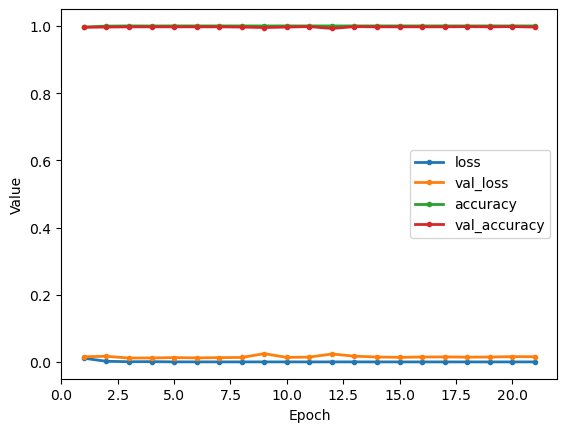

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/57 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
768,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
884,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431,0.002198,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2725,0.003344,0.0,0.0,0.003344,0.0,0.003344,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7947,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      38,727,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,768,641 (147.89 MB)

 Trainable params: 38,768,641 (147.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1:22 903ms/step - accuracy: 0.4688 - loss: 0.6932

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.4766 - loss: 0.6931 

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.4965 - loss: 0.6931

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.5072 - loss: 0.6930

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.5176 - loss: 0.6930

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.5247 - loss: 0.6929

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.5294 - loss: 0.6928

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.5338 - loss: 0.6927

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.5356 - loss: 0.6927

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.5372 - loss: 0.6925

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.5380 - loss: 0.6924

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.5388 - loss: 0.6923

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.5391 - loss: 0.6921

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5386 - loss: 0.6920

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5380 - loss: 0.6918

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5382 - loss: 0.6917

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.5393 - loss: 0.6915

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.5412 - loss: 0.6913

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.5438 - loss: 0.6911

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.5469 - loss: 0.6908 

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.5504 - loss: 0.6905

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.5540 - loss: 0.6902

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.5574 - loss: 0.6899

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.5606 - loss: 0.6895

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.5636 - loss: 0.6891

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.5663 - loss: 0.6887

27/92 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.5689 - loss: 0.6882

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.5714 - loss: 0.6877

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.5742 - loss: 0.6871

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.5771 - loss: 0.6866

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.5802 - loss: 0.6859

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.5834 - loss: 0.6853

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.5867 - loss: 0.6846

34/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.5901 - loss: 0.6838

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.5935 - loss: 0.6830

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.5969 - loss: 0.6822

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6003 - loss: 0.6813

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6036 - loss: 0.6803

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6070 - loss: 0.6793

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6104 - loss: 0.6782

41/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.6137 - loss: 0.6771

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6170 - loss: 0.6759

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6203 - loss: 0.6746

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6236 - loss: 0.6733

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6268 - loss: 0.6720

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6300 - loss: 0.6706

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6332 - loss: 0.6691

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6363 - loss: 0.6676

49/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.6394 - loss: 0.6660

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.6424 - loss: 0.6643

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.6454 - loss: 0.6626

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.6484 - loss: 0.6608

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.6513 - loss: 0.6590

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.6542 - loss: 0.6571

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.6570 - loss: 0.6552

56/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.6598 - loss: 0.6532

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.6625 - loss: 0.6512

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.6652 - loss: 0.6491

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6679 - loss: 0.6470

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6705 - loss: 0.6449

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6731 - loss: 0.6427

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6756 - loss: 0.6405

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.6781 - loss: 0.6383

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6806 - loss: 0.6360

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6830 - loss: 0.6337

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6854 - loss: 0.6314

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6877 - loss: 0.6291

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6900 - loss: 0.6267

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6923 - loss: 0.6244

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6945 - loss: 0.6220

71/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6967 - loss: 0.6196

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.6989 - loss: 0.6172

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7010 - loss: 0.6148

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7031 - loss: 0.6124

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7052 - loss: 0.6100

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7072 - loss: 0.6076

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7092 - loss: 0.6051

78/92 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7112 - loss: 0.6027

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7131 - loss: 0.6003

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7150 - loss: 0.5979

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7169 - loss: 0.5955

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7188 - loss: 0.5931

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7206 - loss: 0.5906

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7224 - loss: 0.5882

85/92 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7242 - loss: 0.5859

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7259 - loss: 0.5835

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7277 - loss: 0.5811

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7294 - loss: 0.5787

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7310 - loss: 0.5764

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7327 - loss: 0.5740

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7343 - loss: 0.5717

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7359 - loss: 0.5694

92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - accuracy: 0.7375 - loss: 0.5671 - val_accuracy: 0.9973 - val_loss: 0.0146


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 28s 315ms/step - accuracy: 1.0000 - loss: 0.0065

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 1.0000 - loss: 0.0068

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 0.0072

 4/92 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 0.0074

 5/92 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.9994 - loss: 0.0079

 6/92 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.9990 - loss: 0.0081

 7/92 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.9989 - loss: 0.0082

 8/92 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.9983 - loss: 0.0088

 9/92 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.9979 - loss: 0.0092

10/92 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.9976 - loss: 0.0095

11/92 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.9975 - loss: 0.0097

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9973 - loss: 0.0098

13/92 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.9973 - loss: 0.0099

14/92 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9972 - loss: 0.0100

15/92 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9972 - loss: 0.0101

16/92 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9972 - loss: 0.0101

17/92 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9972 - loss: 0.0101

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9972 - loss: 0.0101

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9972 - loss: 0.0100

20/92 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9972 - loss: 0.0100

21/92 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9973 - loss: 0.0099

22/92 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9973 - loss: 0.0099

23/92 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9973 - loss: 0.0099

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9972 - loss: 0.0100 

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9972 - loss: 0.0100

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9972 - loss: 0.0100

27/92 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9972 - loss: 0.0101

28/92 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9972 - loss: 0.0101

29/92 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9972 - loss: 0.0101

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9972 - loss: 0.0101

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9972 - loss: 0.0100

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9972 - loss: 0.0100

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9973 - loss: 0.0100

34/92 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9973 - loss: 0.0100

35/92 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9973 - loss: 0.0100

36/92 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9973 - loss: 0.0100

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9973 - loss: 0.0100

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9973 - loss: 0.0100

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9973 - loss: 0.0100

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9973 - loss: 0.0100

41/92 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9973 - loss: 0.0099

42/92 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9973 - loss: 0.0099

43/92 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9973 - loss: 0.0099

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9973 - loss: 0.0099

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9973 - loss: 0.0098

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9973 - loss: 0.0098

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9973 - loss: 0.0098

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9973 - loss: 0.0098

49/92 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9973 - loss: 0.0097

50/92 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9973 - loss: 0.0097

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9974 - loss: 0.0097

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9974 - loss: 0.0096

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9974 - loss: 0.0096

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9974 - loss: 0.0096

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9974 - loss: 0.0095

56/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9974 - loss: 0.0095

57/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9974 - loss: 0.0095

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9974 - loss: 0.0095

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9974 - loss: 0.0095

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9974 - loss: 0.0095

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9974 - loss: 0.0094

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9975 - loss: 0.0094

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9975 - loss: 0.0094

64/92 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9975 - loss: 0.0094

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9975 - loss: 0.0094

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9975 - loss: 0.0094

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9975 - loss: 0.0093

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9975 - loss: 0.0093

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9975 - loss: 0.0093

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9975 - loss: 0.0093

71/92 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9975 - loss: 0.0093

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9975 - loss: 0.0093

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9976 - loss: 0.0092

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9976 - loss: 0.0092

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9976 - loss: 0.0092

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9976 - loss: 0.0092

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9976 - loss: 0.0092

78/92 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9976 - loss: 0.0091

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9976 - loss: 0.0091

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9976 - loss: 0.0091

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9976 - loss: 0.0091

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9976 - loss: 0.0091

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9976 - loss: 0.0091

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9977 - loss: 0.0090

85/92 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9977 - loss: 0.0090

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9977 - loss: 0.0090

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9977 - loss: 0.0090

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9977 - loss: 0.0090

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9977 - loss: 0.0090

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9977 - loss: 0.0089

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9977 - loss: 0.0089

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9977 - loss: 0.0089

92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.9977 - loss: 0.0089 - val_accuracy: 0.9979 - val_loss: 0.0063


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 26s 286ms/step - accuracy: 1.0000 - loss: 0.0022

 2/92 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 0.0021

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 0.0020

 4/92 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 1.0000 - loss: 0.0019

 5/92 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 1.0000 - loss: 0.0018

 6/92 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 1.0000 - loss: 0.0018

 7/92 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 1.0000 - loss: 0.0017

 8/92 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 1.0000 - loss: 0.0017

 9/92 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 0.0016

10/92 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0016

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 0.0016

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 0.0016

13/92 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 0.0015

14/92 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 0.0015

15/92 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 0.0015

16/92 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 0.0015

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 0.0014

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 0.0014

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 0.0014

20/92 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 0.0014

21/92 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 0.0014

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 0.0014 

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 0.0013

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 0.0013

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 0.0013

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 0.0013

27/92 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 0.0013

28/92 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 0.0013

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 0.0013

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 0.0013

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 0.0013

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 0.0013

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 0.0012

34/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 0.0012

35/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 0.0012

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 0.0012

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 0.0012

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 0.0012

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 0.0012

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 0.0012

41/92 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 0.0012

42/92 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 0.0012

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 0.0012

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 0.0012

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 0.0012

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 0.0012

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 0.0012

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 0.0012

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0012

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0012

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0012

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0012

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 0.0012

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 0.0012

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 0.0012

56/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0012

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 0.0012

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 0.0011

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 0.0011

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 0.0011

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 0.0011

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 0.0011

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 0.0011

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 0.0011

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 0.0011

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 0.0011

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 0.0011

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 0.0011

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 0.0011

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 0.0011

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 0.0011

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 0.0011

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 0.0011

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 0.0011

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 0.0011

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 0.0011

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 0.0011

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 0.0011

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 0.0011

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 0.0011

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 0.0011

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 0.0011

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 0.0011

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 0.0011

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 0.0011

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 0.0011

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9999 - loss: 0.0011

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9999 - loss: 0.0011

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9999 - loss: 0.0011

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9999 - loss: 0.0011

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9999 - loss: 0.0011

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9999 - loss: 0.0011

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9979 - val_loss: 0.0051


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 23s 262ms/step - accuracy: 1.0000 - loss: 4.1410e-04

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 1.0000 - loss: 4.3965e-04

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 4.4898e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 4.8317e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 4.9072e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 4.9648e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 5.0670e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 5.1025e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 5.1208e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 5.1166e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 5.1102e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 5.0970e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 5.0779e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 5.0481e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 5.0126e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.9733e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.9360e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 4.8972e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 4.8687e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 4.8395e-04 

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 4.8097e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 4.7836e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 4.7549e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 4.7286e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 4.7039e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 4.6785e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 4.6568e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 4.6357e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 4.6152e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 4.5955e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.5753e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 4.5568e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 4.5478e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 4.5380e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 4.5304e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 4.5223e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 4.5133e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 4.5040e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 4.4935e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 4.4825e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 4.4796e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 4.4758e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 4.4713e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 4.4658e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 4.4608e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 4.4558e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 4.4508e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 4.4456e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 4.4400e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 4.4342e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 4.4279e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 4.4212e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 4.4145e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 4.4074e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 4.4005e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 4.3934e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 4.3862e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 4.3792e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 4.3718e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.3642e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.3566e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.3498e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 4.3429e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 4.3356e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 4.3284e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 4.3213e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 4.3140e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 4.3064e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 4.2988e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 4.2912e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 4.2833e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 4.2756e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 4.2677e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 4.2599e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 4.2521e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 4.2455e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 4.2389e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 4.2320e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 4.2264e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 4.2217e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 4.2232e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 4.2243e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 4.2252e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 4.2258e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 4.2262e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 4.2266e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 4.2267e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 4.2267e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 4.2263e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 4.2258e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 4.2250e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 4.2244e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 4.2238e-04 - val_accuracy: 0.9979 - val_loss: 0.0060


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - accuracy: 1.0000 - loss: 2.8537e-04

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 2.8096e-04

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 2.6726e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 2.5484e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 2.4972e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 2.4536e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 2.4219e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 2.3961e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 2.5279e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 2.6442e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 2.7266e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 2.7879e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 2.8312e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 2.8665e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 2.8974e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 2.9271e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 2.9494e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 2.9654e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 2.9760e-04 

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 2.9830e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 2.9875e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 2.9898e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 2.9943e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 2.9995e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 3.0030e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 3.0046e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 3.0044e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 3.0030e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 3.0015e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 2.9979e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 2.9925e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 2.9861e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 2.9794e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.9716e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.9628e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.9545e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.9472e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.9392e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.9308e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.9220e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.9128e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.9031e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.8930e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.8825e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.8718e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.8608e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.8496e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.8387e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.8280e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.8199e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.8115e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.8034e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.7955e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.7877e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.7801e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.7724e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.7645e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.7572e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.7497e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.7421e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.7349e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 2.7277e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.7230e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.7180e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 2.7128e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 2.7076e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 2.7021e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 2.6969e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 2.6916e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 2.6862e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 2.6810e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 2.6761e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 2.6718e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.6676e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.6633e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.6590e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.6547e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.6503e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.6458e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.6414e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.6368e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.6322e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.6275e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.6227e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.6180e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.6133e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.6088e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.6044e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.6001e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.5958e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.5914e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.5872e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.5831e-04 - val_accuracy: 0.9973 - val_loss: 0.0104


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 1.0000 - loss: 1.7195e-04

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.5939e-04

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 1.6422e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 1.6143e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 1.5684e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 1.5647e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 1.5722e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 1.5728e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 1.5789e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 1.5818e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 1.5814e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 1.5763e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 1.5736e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 1.5694e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 1.5671e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 1.5645e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 1.5600e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 1.5552e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 1.5501e-04 

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 1.5443e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 1.5395e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 1.5335e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 1.5285e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 1.5250e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 1.5210e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 1.5163e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 1.5108e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.5056e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 1.5000e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.4948e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.4893e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.4839e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.4787e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.4740e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 1.4695e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 1.4646e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 1.4597e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 1.4569e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 1.4539e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 1.4509e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.4479e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.4451e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.4424e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.4395e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.4365e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.4362e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.4362e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.4359e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.4352e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.4342e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.4333e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.4322e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.4314e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.4306e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.4295e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.4283e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.4271e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.4261e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.4248e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.4237e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.4226e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.4214e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.4201e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 1.4189e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 1.4175e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.4161e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.4146e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 1.4131e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 1.4116e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 1.4100e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 1.4084e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 1.4066e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 1.4050e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 1.4040e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 1.4038e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 1.4035e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 1.4030e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.4026e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.4021e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.4014e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.4009e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.4059e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.4107e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 1.4152e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.4195e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.4236e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.4275e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.4314e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.4352e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.4388e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.4424e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 1.4459e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 1.0000 - loss: 1.4494e-04 - val_accuracy: 0.9979 - val_loss: 0.0050


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 25s 280ms/step - accuracy: 1.0000 - loss: 1.7972e-04

 2/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.6833e-04

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 1.6481e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 1.6183e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 1.5691e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 1.5450e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 1.5497e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 1.5473e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 1.5453e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 1.5808e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 1.6146e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 1.6651e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 1.7062e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 1.7375e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 1.7668e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 1.7879e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 1.8079e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 1.8236e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 1.8364e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 1.8441e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 1.8479e-04 

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 1.8503e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 1.8503e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 1.8488e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 1.8461e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 1.8425e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 1.8374e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 1.8346e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 1.8310e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 1.8283e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 1.8248e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 1.8218e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 1.8182e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 1.8145e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.8104e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.8061e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.8015e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.7973e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.7928e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.7880e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 1.7830e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.7777e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.7721e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.7663e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.7606e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.7550e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.7491e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.7432e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.7371e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.7310e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.7248e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.7186e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.7125e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.7062e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 1.6999e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 1.6936e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.6873e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.6809e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.6745e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.6680e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 1.6617e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 1.6557e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 1.6497e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.6437e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.6377e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 1.6318e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 1.6258e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 1.6200e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 1.6142e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.6086e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 1.6032e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 1.5980e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 1.5928e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 1.5876e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 1.5823e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 1.5773e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 1.5723e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.5673e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.5623e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.5574e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.5529e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.5483e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.5438e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.5393e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.5373e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.5352e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.5330e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.5308e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.5294e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.5279e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.5267e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.5256e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.5245e-04 - val_accuracy: 0.9979 - val_loss: 0.0087


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 1.0000 - loss: 6.6388e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 6.8887e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 1.0000 - loss: 6.7202e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 6.5122e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 6.2857e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 6.3726e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 6.4004e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 6.3916e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 6.3929e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 6.4055e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 6.4303e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 8.8613e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 1.0741e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 1.2210e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3356e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.4279e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.5015e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.5598e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 1.6061e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 1.6421e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 1.6707e-04 

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 1.6967e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 1.7312e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 1.7592e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 1.7815e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 1.7995e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 1.8147e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 1.8266e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 1.8358e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 1.8453e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 1.8527e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 1.8582e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 1.8623e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 1.8648e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.8659e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.8661e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.8651e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.8667e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.8672e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.8669e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 1.8671e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 1.8669e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 1.8659e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 1.8643e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 1.8624e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 1.8598e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 1.8568e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.8534e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 1.8495e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 1.8456e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 1.8413e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 1.8375e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.8336e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.8297e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.8256e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.8213e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.8168e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.8124e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.8079e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.8033e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.7987e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.7941e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.7893e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.7845e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.7795e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.7745e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 1.7695e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.7644e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.7593e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 1.7541e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 1.7489e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 1.7437e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 1.7385e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 1.7332e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 1.7279e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 1.7226e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 1.7173e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 1.7120e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 1.7068e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 1.7016e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 1.6964e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 1.6913e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 1.6862e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 1.6812e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 1.6763e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 1.6715e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 1.6666e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.6617e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.6570e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.6522e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.6475e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 1.6429e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.6384e-04 - val_accuracy: 0.9959 - val_loss: 0.0122


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - accuracy: 1.0000 - loss: 9.8880e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 8.5528e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 1.0000 - loss: 7.9805e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 7.6632e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 7.4032e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 7.1256e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 6.8860e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 6.6973e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 6.5252e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 6.3710e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 6.2449e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 6.2280e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 6.3383e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 6.4715e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 6.5898e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 6.6906e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 6.7604e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 6.8446e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 6.9042e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 6.9472e-05 

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 6.9741e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 7.1371e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 7.2767e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 7.3935e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 7.4885e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 7.5638e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 7.7051e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 7.8240e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 7.9249e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 8.0131e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 8.0890e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 8.1534e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 8.2079e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 8.2597e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 8.3035e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 8.3394e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 8.3699e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 8.3967e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 8.4174e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 8.4325e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 8.4443e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 8.4547e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 8.4646e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 8.4739e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 8.4796e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 8.4844e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 8.4874e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 8.4904e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 8.4976e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 8.5034e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 8.5090e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 8.5244e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 8.5375e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 8.5525e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 8.5654e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 8.5773e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 8.5871e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 8.5959e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 8.6028e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 8.6078e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 8.6110e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 8.6123e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 8.6122e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 8.6155e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 8.6173e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 8.6181e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 8.6175e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 8.6165e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 8.6145e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 8.6121e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 8.6087e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 8.6063e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 8.6034e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 8.5995e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 8.5949e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 8.5897e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 8.5848e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 8.5798e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 8.5742e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 8.5679e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 8.5613e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 8.5540e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 8.5462e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 8.5384e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 8.5302e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 8.5213e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 8.5121e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 8.5027e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 8.4928e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 8.4826e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 8.4720e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 8.4614e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 8.4511e-05 - val_accuracy: 0.9973 - val_loss: 0.0116


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - accuracy: 1.0000 - loss: 2.1540e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 2.1674e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 2.1837e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 2.5942e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 3.0997e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 3.7918e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 4.2125e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 4.4444e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 4.6063e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 4.6920e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 4.8378e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 4.9963e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 5.1058e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 5.1816e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 5.2750e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 5.3455e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 5.3891e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 5.4249e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 5.4483e-05 

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 5.4674e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 5.4793e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 5.4820e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 5.4844e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 5.4860e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 5.4813e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 5.4737e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 5.4650e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 5.4532e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 5.4386e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 5.4301e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 5.4199e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 5.4092e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 5.4116e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 5.4156e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 5.4166e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 5.4147e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 5.4123e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 5.4082e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 5.4040e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 5.3989e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 5.3921e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 5.3844e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 5.3779e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 5.3696e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 5.3605e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 5.3510e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 5.3425e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 5.3328e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.3224e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.3127e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.3020e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.2908e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 5.2819e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 5.2724e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 5.2625e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.2540e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.2453e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.2366e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.2278e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.2183e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.2088e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.1992e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.1899e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.1804e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.1711e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.1651e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.1587e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.1518e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.1446e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.1381e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.1319e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.1261e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.1201e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 5.1138e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.1126e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.1110e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 5.1090e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.1070e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 5.1050e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.1024e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.0995e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.0964e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.0930e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.0892e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 5.0858e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.0819e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.0779e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.0737e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.0693e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.0646e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 5.0598e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 5.0550e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 5.0503e-05 - val_accuracy: 0.9973 - val_loss: 0.0110


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 19s 220ms/step - accuracy: 1.0000 - loss: 3.5320e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 3.4736e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 3.4048e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 3.2631e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.1641e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 3.1052e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 3.0808e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 3.0566e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 3.0567e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 3.0752e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 3.0845e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 3.0843e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 3.1250e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 3.1675e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 3.1999e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 3.2304e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 3.2487e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 3.2636e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 3.2720e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 3.2792e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 3.2828e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 3.2812e-05 

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 3.2792e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 3.2743e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 3.2711e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 3.2661e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 3.2593e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 3.2509e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 3.2433e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 3.2373e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 3.2338e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 3.2291e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 3.2235e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 3.2221e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 3.2192e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 3.2155e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 3.2107e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 3.2061e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 3.2027e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 3.1982e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 3.1933e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 3.1882e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 3.1843e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 3.1805e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 3.1762e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 3.1720e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 3.1693e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 3.1661e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 3.1630e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 3.1593e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 3.1554e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 3.1513e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 3.1476e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 3.1438e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 3.1395e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 3.1352e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 3.1318e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 3.1284e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 3.1266e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 3.1242e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 3.1223e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 3.1200e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 3.1177e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 3.1160e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 3.1142e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 3.1126e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 3.1107e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 3.1087e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 3.1066e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 3.1059e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 3.1051e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 3.1044e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 3.1039e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 3.1053e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.1071e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 3.1097e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 3.1120e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.1143e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 3.1166e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.1187e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 3.1212e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 3.1234e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 3.1252e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 3.1270e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.1285e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.1297e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.1306e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.1315e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.1324e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 3.1330e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 3.1333e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 3.1336e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 3.1340e-05 - val_accuracy: 0.9966 - val_loss: 0.0121


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - accuracy: 1.0000 - loss: 1.8734e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 1.0000 - loss: 2.0425e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 1.0000 - loss: 2.1043e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 1.0000 - loss: 2.0828e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 1.0000 - loss: 2.2127e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 1.0000 - loss: 2.2931e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.3548e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 2.4164e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 2.4463e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 2.4572e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.4537e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.4863e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.5079e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 2.5162e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 2.5239e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 2.5437e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 2.5782e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 2.6058e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 2.6669e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 2.7156e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 2.7659e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 2.8217e-05 

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 2.8679e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 2.9064e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 2.9436e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 2.9763e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 3.0367e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 3.0898e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 3.1408e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 3.1852e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 3.2278e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 3.2670e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 3.3029e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 3.3339e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 3.3633e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 3.3917e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 3.4190e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.4429e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.4641e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.4824e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.4983e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.5126e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.5263e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 3.5378e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 3.5478e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 3.5568e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 3.5643e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 3.5705e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 3.5754e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 3.5809e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 3.5859e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 3.5907e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 3.5961e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 3.6213e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 3.6444e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 3.6654e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 3.6848e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 3.7025e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 3.7186e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 3.7338e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 3.7479e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 3.7616e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 3.7747e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 3.7866e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 3.7978e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 3.8107e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 3.8226e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 3.8338e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 3.8449e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 3.8557e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 3.8659e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 3.8752e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 3.8836e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 3.8912e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.8980e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.9042e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 3.9100e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.9150e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.9197e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.9238e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.9273e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.9306e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.9335e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 3.9358e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.9377e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.9391e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.9402e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.9410e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.9414e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.9423e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.9427e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 3.9431e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 3.9435e-05 - val_accuracy: 0.9959 - val_loss: 0.0128



[Train Accuracy: 100.00% - Test Accuracy: 99.56%]


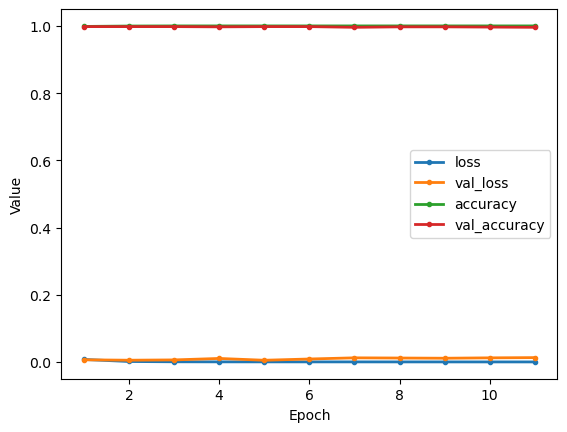

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step

 5/57 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 

 9/57 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

13/57 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

17/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

21/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

25/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

29/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

33/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

38/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

46/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 1/57 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step

 4/57 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

 8/57 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

12/57 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

16/57 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

20/57 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

24/57 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

28/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

33/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

38/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

43/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/HSF/report_T2VI3K8W.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################